# Object detection, Part 1
## Vicky Kalogeiton

# Object detection 
Here is an example of object detection results in images not seen during training. 

![SSD results](https://drive.google.com/uc?export=view&id=1pBdZzxj9fNb9MFB1xWJC6vqwSNnrttxX)


# Bounding box

In object detection, we usually use a bounding box to describe the target location. 
The bounding box is a rectangular box that can be determined by the $x_{min}$ and $y_{min}$ axis coordinates in the upper-left corner and the $x_{max}$ and $y_{max}$ axis coordinates in the lower-right corner of the rectangle.
Another commonly used bounding box representation is the $x$ and $y$ axis coordinates of the bounding box center, and its width and height.

## Boundary coordinates
The most obvious way to represent a box is by the pixel coordinates of the x and y lines that constitute its boundaries. 

![](https://drive.google.com/uc?export=view&id=1eZzdJuWQNBGlG281ftzBJL3ksy5RoSju)


The boundary coordinates of a box are simply ($x_{min}, y_{min}, x_{max}, y_{max}$).

But pixel values are next to useless if we don't know the actual dimensions of the image. A better way would be to represent all coordinates is in their fractional form.

![](https://drive.google.com/uc?export=view&id=1yp53hwbbpYQjWF38TDRlZP6a4ElaMm3B)

Now the coordinates are size-invariant and all boxes across all images are measured on the same scale.

## Center-Size coordinates

This is a more explicit way of representing a box's position and dimensions.


![](https://drive.google.com/uc?export=view&id=1FlISEm5jnrJ_WX-14Cr4hRGSj3ubVJt8)


The center-size coordinates of a box are ($c_x, c_y, w, h$).

## Bounding boxes

The image below displays two objects, a dog on the left and a cat on the right. 

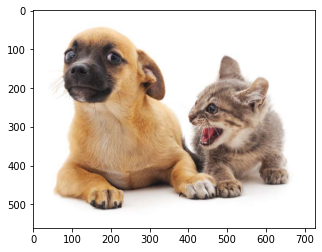

In [ ]:
import numpy as np
import pandas as pd
import cv2 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt
      
img = io.imread('http://vicky.kalogeiton.info/assets/catdog.jpeg')
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()


# Question 1 - a
You need to create the following two functions: 
* a function `box_corner_to_center` that converts from the two-corner representation to the center-width-height presentation, 
and 
* a function `box_center_to_corner` that does the reverse. 

The input argument `boxes` can be either a length $4$ tensor,
or a $(N, 4)$ 2-dimensional tensor.



In [ ]:
import torch

def box_corner_to_center(boxes):
    """Convert boxes from (upper_left, bottom_right) 
    to (center, width, height)
    """
    squeeze = False
    if len(boxes.size())==1:
      squeeze = True
      boxes.unsqueeze(0)
    N = boxes.size()[0]
    for i in range(N):
      x_c = (boxes[i][0]+ boxes[i][2])/2
      y_c = (boxes[i][1]+ boxes[i][3])/2
      w = boxes[i][2]- boxes[i][0]
      h = boxes[i][3]- boxes[i][1]
      boxes[i] = torch.tensor([x_c, y_c, w, h])
    if (squeeze):
      boxes = boxes.reshape(4)
    return boxes

def box_center_to_corner(boxes):
    """Convert boxes from (center, width, height) 
    to (upper_left, bottom_right)
    """
    squeeze = False
    if len(boxes.size())==1:
      squeeze = True
      boxes.unsqueeze(0)
    N = boxes.size()[0]
    for i in range(N):
      x_min = boxes[i][0] - boxes[i][2]/2
      y_min = boxes[i][1] - boxes[i][3]/2
      x_max = boxes[i][0] + boxes[i][2]/2
      y_max = boxes[i][1] + boxes[i][3]/2
      boxes[i] = torch.tensor([x_min, y_min, x_max, y_max])
    if (squeeze):
      boxes = boxes.reshape(4)

    return boxes

We will define the bounding boxes of the dog and the cat in the image based on the coordinate information. Note the bounding box is often called `bbox`.  

The origin of the coordinates in the image is the upper left corner of the image, and to the right and down are the positive directions of the $x$ axis and the $y$ axis, respectively. 




In [ ]:
# bbox is the abbreviation for bounding box
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

We can verify the correctness of box conversion functions by converting twice.


In [ ]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) - boxes

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]])

# Question 1 - b

You need to draw the bounding box in the image to check if it is accurate. To draw the box, you need to create a "helper" function `bbox_to_rect`. It represents the bounding box in the bounding box format of `matplotlib`. 
Also, if the `class_name` is given, then print it. 

Help: you need to use `rectangle` and `putText` from `cv2` ([source](https://www.geeksforgeeks.org/python-opencv-cv2-rectangle-method/)). 


In [ ]:
def bbox_to_rect(im, bbox, edgecolor=None, linewidth=2, class_name=None):
    """Draw the bounding box"""
    x_min, y_min, x_max, y_max = map(int, bbox)
    im = cv2.rectangle(im, (x_min, y_min), (x_max, y_max), color = edgecolor)
    im = cv2.putText(im, class_name,(x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, edgecolor, 2)
    return im


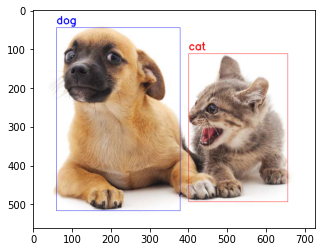

In [ ]:
img = io.imread('http://vicky.kalogeiton.info/assets/catdog.jpeg')
img_drawn = bbox_to_rect(img, dog_bbox, edgecolor=(0,0,255), class_name='dog') # blue
img_drawn = bbox_to_rect(img_drawn, cat_bbox, edgecolor=(255,0,0), class_name='cat') # red
plt.imshow(img_drawn)

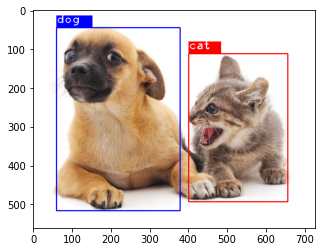

In [ ]:
img = io.imread('http://vicky.kalogeiton.info/assets/catdog.jpeg')
img_drawn = bbox_to_rect(img, dog_bbox, edgecolor=(0,0,255), class_name='dog') # blue
img_drawn = bbox_to_rect(img_drawn, cat_bbox, edgecolor=(255,0,0), class_name='cat') # red
plt.imshow(img_drawn)

# Single-Shot Object detection

Some architectures for object detection consist of two distinct stages – a region proposal network (RPN) that performs object localization and a classifier for detecting the types of objects in the proposed regions. Computationally, these can be very expensive and therefore ill-suited for real-world, real-time applications. Single-shot models encapsulate both localization and detection tasks in a single forward sweep of the network, resulting in significantly faster detections while deployable on lighter hardware.

### Multiscale Feature Maps 

In image classification tasks, we base our predictions on the final convolutional feature map – the smallest but deepest representation of the original image. 

In object detection, feature maps from intermediate convolutional layers can also be directly useful because they represent the original image at different scales. Therefore, a fixed-size filter operating on different feature maps will be able to detect objects of various sizes.

### A. Anchors-Priors-Default boxes

These are pre-computed boxes defined at specific positions on specific feature maps, with specific aspect ratios and scales. They are carefully chosen to match the characteristics of objects' bounding boxes (i.e. the ground truths) in the dataset.

### B. Multibox

This is a technique that formulates predicting an object's bounding box as a regression problem, where a detected object's coordinates are regressed to its ground truth's coordinates. In addition, for each predicted box, scores are generated for various object types. Anchor boxes serve as feasible starting points for predictions because they are modeled on the ground truths. Therefore, there will be as many predicted boxes as there are anchors, most of whom will contain no object.

# A. Anchor Boxes

Object detection algorithms usually sample a large number of regions in the input image, determine whether these regions contain objects of interest, and adjust the edges of the regions so as to predict the ground-truth bounding box of the target more accurately. Different models may use different region sampling methods. 

Here, we introduce one such method: it generates multiple bounding boxes with different sizes and aspect ratios while centering on each pixel. These bounding boxes are called anchor boxes (or priors or default boxes or simply anchors). We will practice object detection based on anchor boxes in the following sections.


## B. Multibox 

Multibox is a technique for detecting objects where a prediction consists of two components:

* Coordinates of a box that may or may not contain an object. This is a regression task.
* Scores for various object types for this box, including a background class which implies there is no object in the box. This is a classification task.


### Generating Multiple Anchor Boxes

Assume that the input image has a height of $h$ and width of $w$. We generate anchor boxes with different shapes centered on each pixel of the image. Assume the size is $s\in (0, 1]$, the aspect ratio is $r > 0$, and the width and height of the anchor box are $ws\sqrt{r}$ and $hs/\sqrt{r}$, respectively.  When the center position is given, an anchor box with known width and height is determined.

Below we set a set of sizes $s_1,\ldots, s_n$ and a set of aspect ratios $r_1,\ldots, r_m$. If we use a combination of all sizes and aspect ratios with each pixel as the center, the input image will have a total of $whnm$ anchor boxes. Although these anchor boxes may cover all ground-truth bounding boxes, the computational complexity is often excessive. Therefore, we are usually only interested in a combination containing $s_1$ or $r_1$ sizes and aspect ratios, that is:

$$(s_1, r_1), (s_1, r_2), \ldots, (s_1, r_m), (s_2, r_1), (s_3, r_1), \ldots, (s_n, r_1).$$

That is, the number of anchor boxes centered on the same pixel is $n+m-1$. For the entire input image, we will generate a total of $wh(n+m-1)$ anchor boxes.

The above method of generating anchor boxes has been implemented in the `multibox_prior` function. We specify the input, a set of sizes, and a set of aspect ratios, and this function will return all the anchor boxes entered.


In [ ]:
def multibox_prior(data, sizes, ratios):
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # Offsets are required to move the anchor to center of a pixel
    # Since pixel (height=1, width=1), we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generate boxes_per_pixel number of heights and widths which are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    # cat (various sizes, first ratio) and (first size, various ratios)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack(
        (-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2

    # Each center point will have boxes_per_pixel number of anchor boxes, so
    # generate grid of all anchor box centers with boxes_per_pixel repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                           dim=1).repeat_interleave(boxes_per_pixel, dim=0)

    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

We can see that the shape of the returned anchor box variable `y` is
(batch size, number of anchor boxes, 4).


In [ ]:
img = io.imread('http://vicky.kalogeiton.info/assets/catdog.jpeg')
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[0:2]

print("The height and width of the image are ({}, {})".format(h, w))

# Construct input data
X = torch.rand(size=(1, 3, h, w))  
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
print("The shape of the multiboxes we generated is {},".format(Y.detach().numpy().shape))
print("with batch_size={}, number of anchor boxes ={}, coordinates= {}".format(
    Y.detach().numpy().shape[0],Y.detach().numpy().shape[1],Y.detach().numpy().shape[2]))

print("Note that w x h x (s+r-1) = {} x {} x ({}+{}-1) = {} anchors".format(w, h, 3, 3, Y.detach().numpy().shape[1]))

The height and width of the image are (561, 728)
The shape of the multiboxes we generated is (1, 2042040, 4),
with batch_size=1, number of anchor boxes =2042040, coordinates= 4
Note that w x h x (s+r-1) = 728 x 561 x (3+3-1) = 2042040 anchors


After changing the shape of the anchor box variable `y` to (image height, image width, number of anchor boxes centered on the same pixel, 4), we can obtain all the anchor boxes centered on a specified pixel position. 

In the following example, we access the first anchor box centered on (250, 250). It has four elements: the $x_{1}, y_{1}$ axis coordinates in the upper-left corner and the $x_{2}, y_{2}$ axis coordinates in the lower-right corner of the anchor box. The coordinate values of the $x$ and $y$ axis are divided by the width and height of the image, respectively, so the value range is between 0 and 1.


In [ ]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([0.0551, 0.0715, 0.6331, 0.8215])

To describe all the anchor boxes on one pixel, we use the `print_boxes` function that draws multiple bounding boxes (i.e., the `boxes` variable from above) on the image for each position. 

In [ ]:
import random
import colorsys

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    def times255(x):
      return x * 255
    colors = [list(map(times255, x)) for ii, x in enumerate(colors)]
    
    return colors


As we just saw, the coordinate values of the $x$ and $y$ axis in the variable `boxes` have been divided by the width and height of the image, respectively. When drawing images, we need to restore the original coordinate values of the anchor boxes and therefore define the variable `bbox_scale`. Now, we can draw all the anchor boxes centered on (250, 250) in the image. As you can see, the blue anchor box with a size of 0.75 and an aspect ratio of 1 covers the dog in the image well.


In [ ]:
def print_boxes(img, boxes_to_print, bbox_scale, class_names, linewidth, colors):

  for ii in range(boxes_to_print.shape[0]):
    drawn_img = bbox_to_rect(img, boxes_to_print[ii,:] * bbox_scale, class_name=class_names[ii], 
                             linewidth=linewidth, edgecolor=colors[ii]) 
  
  return drawn_img 

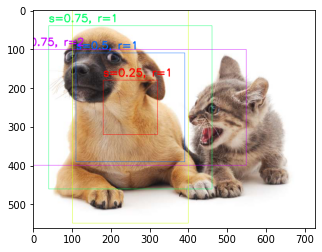

In [ ]:
bbox_scale = torch.tensor((w, h, w, h))
boxes_to_print = boxes[250, 250, :, :]
colors = random_colors(boxes_to_print.shape[0])
class_names = ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2', 's=0.75, r=0.5']

img1 = print_boxes(img, boxes[250, 250, :, :], bbox_scale, class_names, linewidth=2, colors=colors)
fig = plt.imshow(img1)

# Jaccard Index (Intersection over Union)

We just mentioned that the anchor box covers the dog in the image well. If the ground-truth bounding box of the target is known, how can "well" here be quantified? An intuitive method is to measure the similarity between anchor boxes and the ground-truth bounding box. We know that the Jaccard index can measure the similarity between two sets. Given sets $\mathcal{A}$ and $\mathcal{B}$, their Jaccard index is the size of their intersection divided by the size of their union:

$$J(\mathcal{A},\mathcal{B}) = \frac{\left|\mathcal{A} \cap \mathcal{B}\right|}{\left| \mathcal{A} \cup \mathcal{B}\right|}.$$


In fact, we can consider the pixel area of a bounding box as a collection of pixels. In this way, we can measure the similarity of the two bounding boxes by the Jaccard index of their pixel sets. When we measure the similarity of two bounding boxes, we usually refer the Jaccard index as intersection over union (IoU), which is the ratio of the intersecting area to the union area of the two bounding boxes, as shown in the Figure below. The value range of IoU is between 0 and 1: 0 means that there are no overlapping pixels between the two bounding boxes, while 1 indicates that the two bounding boxes are equal.

![IoU is the ratio of the intersecting area to the union area of two bounding boxes.](http://d2l.ai/_images/iou.svg)


For the remainder of this section, we will use IoU to measure the similarity between anchor boxes and ground-truth bounding boxes, and between different anchor boxes.

# Question 2 

Compute the IoU between two sets of boxes of shapes `(N,4)` and `(M,4)`. 

In [ ]:
def box_iou(boxes1, boxes2):
    """Compute IOU between two sets of boxes of shape (N,4) and (M,4)."""
    # TODO
    # Hint: Compute the area of the bboxes 
    N = boxes1.size()[0]
    M = boxes2.size()[0]
    intersection = torch.zeros((N, M))
    iou = torch.zeros((N, M))
    # Filling the intersections tensor
    for i in range(N):
      for j in range(M):
        x1,y1,X1,Y1 = boxes1[i]
        x2,y2,X2,Y2 = boxes2[j]
        x_left = max(x1,x2)
        y_top = max(y1,y2)
        x_right = min(X1,X2)
        y_down = min(Y1,Y2)
        '''xi_min = max(boxes1[i][0],boxes2[j][0])
        yi_min = max(boxes1[i][1],boxes2[j][1])
        xi_max = min(boxes1[i][2],boxes2[j][2])
        yi_max = min(boxes1[i][3],boxes2[j][3])'''
        if x_left > x_right or y_top > y_down:
          intersection[i,j] = 0
        else:
          intersection[i,j] = (x_right-x_left)*(y_down-y_top)
        surf1 = (boxes1[i][2]-boxes1[i][0])*(boxes1[i][3]-boxes1[i][1])
        surf2 = (boxes2[j][2]-boxes2[j][0])*(boxes2[j][3]-boxes2[j][1])
        union = surf1+surf2-intersection[i, j]
        iou[i,j] = intersection[i,j]/union

    return iou

In [ ]:
print(ground_truth)

tensor([[0.0000, 0.1000, 0.0800, 0.5200, 0.9200],
        [1.0000, 0.5500, 0.2000, 0.9000, 0.8800]])


In [ ]:
box_iou(anchors, ground_truth[:,1:])

tensor([[0.0536, 0.0000],
        [0.1417, 0.0000],
        [0.0000, 0.5657],
        [0.0000, 0.2059],
        [0.0000, 0.7459]])

## Matching anchor boxes to ground truth boxes


In the training set, we consider each anchor box as a training example. In order to train the object detection model, we need to mark two types of labels for each anchor box: first, the category of the target contained in the anchor box (category) and, second, the offset of the ground-truth bounding box relative to the anchor box (offset). 
In object detection, we first generate multiple anchor boxes, predict the categories and offsets for each anchor box, adjust the anchor box position according to the predicted offset to obtain the bounding boxes to be used for prediction, and finally filter out the prediction bounding boxes that need to be output.


We know that, in the object detection training set, each image is labelled with the location of the ground-truth bounding box and the category of the target contained. After the anchor boxes are generated, we primarily label anchor boxes based on the location and category information of the ground-truth bounding boxes similar to the anchor boxes. So how do we assign ground-truth bounding boxes to anchor boxes similar to them?


Assume that the anchor boxes in the image are $A_1, A_2, \ldots, A_{n_a}$ and the ground-truth bounding boxes are $B_1, B_2, \ldots, B_{n_b}$ and $n_a \geq n_b$. Define matrix $\mathbf{X} \in \mathbb{R}^{n_a \times n_b}$, where element $x_{ij}$ in the $i^\mathrm{th}$ row and $j^\mathrm{th}$ column is the IoU of the anchor box $A_i$ to the ground-truth bounding box $B_j$.
First, we find the largest element in the matrix $\mathbf{X}$ and record the row index and column index of the element as $i_1,j_1$. We assign the ground-truth bounding box $B_{j_1}$ to the anchor box $A_{i_1}$. Obviously, anchor box $A_{i_1}$ and ground-truth bounding box $B_{j_1}$ have the highest similarity among all the "anchor box--ground-truth bounding box" pairings. Next, discard all elements in the $i_1$th row and the $j_1$th column in the matrix $\mathbf{X}$. Find the largest remaining element in the matrix $\mathbf{X}$ and record the row index and column index of the element as $i_2,j_2$. We assign ground-truth bounding box $B_{j_2}$ to anchor box $A_{i_2}$ and then discard all elements in the $i_2$th row and the $j_2$th column in the matrix $\mathbf{X}$. At this point, elements in two rows and two columns in the matrix $\mathbf{X}$ have been discarded.


We proceed until all elements in the $n_b$ column in the matrix $\mathbf{X}$ are discarded. At this time, we have assigned a ground-truth bounding box to each of the $n_b$ anchor boxes.
Next, we only traverse the remaining $n_a - n_b$ anchor boxes. Given anchor box $A_i$, find the bounding box $B_j$ with the largest IoU with $A_i$ according to the $i^\mathrm{th}$ row of the matrix $\mathbf{X}$, and only assign ground-truth bounding box $B_j$ to anchor box $A_i$ when the IoU is greater than the predetermined threshold.


As shown in the Figure below on the left, assuming that the maximum value in the matrix $\mathbf{X}$ is $x_{23}$, we will assign ground-truth bounding box $B_3$ to anchor box $A_2$. Then, we discard all the elements in row 2 and column 3 of the matrix, find the largest element $x_{71}$ of the remaining shaded area, and assign ground-truth bounding box $B_1$ to anchor box $A_7$. Then, as shown in the middle part of the Figure below, discard all the elements in row 7 and column 1 of the matrix, find the largest element $x_{54}$ of the remaining shaded area, and assign ground-truth bounding box $B_4$ to anchor box $A_5$.  Finally, as shown on the right part of the Figure below, discard all the elements in row 5 and column 4 of the matrix, find the largest element $x_{92}$ of the remaining shaded area, and assign ground-truth bounding box $B_2$ to anchor box $A_9$.  After that, we only need to traverse the remaining anchor boxes of $A_1, A_3, A_4, A_6, A_8$ and determine whether to assign ground-truth bounding boxes to the remaining anchor boxes according to the threshold.

![Assign ground-truth bounding boxes to anchor boxes. ](https://drive.google.com/uc?export=view&id=1KT3Ucq4cLUmKpsN2CqtrndzEE0scWWve)



In [ ]:
def match_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """Assign ground-truth bounding boxes to anchor boxes similar to them."""

    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element `x_ij` in the `i^th` row and `j^th` column is the IoU
    # of the anchor box `anc_i` to the ground-truth bounding box `box_j`
    jaccard = box_iou(anchors, ground_truth)
    # Initialize the tensor to hold assigned ground truth bbox for each anchor
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, device=device)
    
    # Assign ground truth bounding box according to the threshold
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1)
    box_j = indices[max_ious >= 0.5]
    anchors_bbox_map[anc_i] = box_j
    
    # Find the largest iou for each bbox
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    
    return anchors_bbox_map

## Example 

Below we demonstrate a detailed example. 

We define ground-truth bounding boxes for the cat and dog in the read image, where the first element is category (0 for dog, 1 for cat) and the remaining four elements are the $x_{1}, y_{1}$ axis coordinates at top-left corner and $x_{2}, y_{2}$ axis coordinates at lower-right corner (the value range is between 0 and 1). Here, we construct five anchor boxes to be labeled by the coordinates of the upper-left corner and the lower-right corner, which are recorded as $A_0, \ldots, A_4$, respectively (the index in the program starts from 0). First, draw the positions of these anchor boxes and the ground-truth bounding boxes in the image.


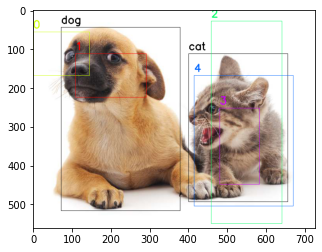

In [ ]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                             [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                        [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                        [0.57, 0.3, 0.92, 0.9]])

img = io.imread('http://vicky.kalogeiton.info/assets/catdog.jpeg')
bbox_scale = torch.tensor((w, h, w, h))
colors = random_colors(anchors.shape[0])
gt_class_names = ['dog', 'cat']
gt_colors = [(0,0,0),(0,0,0)]
anchor_names = ['0', '1', '2', '3', '4']

img1 = print_boxes(img, ground_truth[:,1:], bbox_scale=bbox_scale, class_names=gt_class_names, 
                   linewidth=6, colors=gt_colors)

img1 = print_boxes(img1, anchors, bbox_scale=bbox_scale, class_names=anchor_names, 
                   linewidth=3, colors=colors)
fig = plt.imshow(img1)
plt.imshow(img)

In [ ]:
"""ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                             [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                        [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                        [0.57, 0.3, 0.92, 0.9]])

img = io.imread('http://vicky.kalogeiton.info/assets/catdog.jpeg')
w= 2
h = 3
bbox_scale = torch.tensor((w, h, w, h))
colors = random_colors(anchors.shape[0])
gt_class_names = ['dog', 'cat']
gt_colors = [(0,0,0),(0,0,0)]
anchor_names = ['0', '1', '2', '3', '4']

img1 = print_boxes(img, ground_truth[:,1:], bbox_scale=bbox_scale, class_names=gt_class_names, 
                   linewidth=6, colors=gt_colors)

img1 = print_boxes(img1, anchors, bbox_scale=bbox_scale, class_names=anchor_names, 
                   linewidth=3, colors=colors)
fig = plt.imshow(img1)
plt.imshow(img)"""

"ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],\n                             [1, 0.55, 0.2, 0.9, 0.88]])\nanchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],\n                        [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],\n                        [0.57, 0.3, 0.92, 0.9]])\n\nimg = io.imread('http://vicky.kalogeiton.info/assets/catdog.jpeg')\nw= 2\nh = 3\nbbox_scale = torch.tensor((w, h, w, h))\ncolors = random_colors(anchors.shape[0])\ngt_class_names = ['dog', 'cat']\ngt_colors = [(0,0,0),(0,0,0)]\nanchor_names = ['0', '1', '2', '3', '4']\n\nimg1 = print_boxes(img, ground_truth[:,1:], bbox_scale=bbox_scale, class_names=gt_class_names, \n                   linewidth=6, colors=gt_colors)\n\nimg1 = print_boxes(img1, anchors, bbox_scale=bbox_scale, class_names=anchor_names, \n                   linewidth=3, colors=colors)\nfig = plt.imshow(img1)\nplt.imshow(img)"

## Offsets 

Now we can label the categories and offsets of the anchor boxes. If an anchor box $A$ is assigned ground-truth bounding box $B$, the category of the anchor box $A$ is set to the category of $B$. And the offset of the anchor box $A$ is set according to the relative position of the central coordinates of $B$ and $A$ and the relative sizes of the two boxes. Because the positions and sizes of various boxes in the dataset may vary, these relative positions and relative sizes usually require some special transformations to make the offset distribution more uniform and easier to fit. Assume the center coordinates of anchor box $A$ and its assigned ground-truth bounding box $B$ are $(x_a, y_a), (x_b, y_b)$, the widths of $A$ and $B$ are $w_a, w_b$, and their heights are $h_a, h_b$, respectively. In this case, a common technique is to label the offset of $A$ as

$$\left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x},
\frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right),$$

The default values of the constant are $\mu_x = \mu_y = \mu_w = \mu_h = 0, \sigma_x=\sigma_y=0.1$, and $\sigma_w=\sigma_h=0.2$.

# Question 3
 
Implement this transformation by completing the function  `offset_boxes` below. 

If an anchor box is not assigned a ground-truth bounding box, we only need to set the category of the anchor box to background. 
Anchor boxes whose category is background are often referred to as *negative anchor boxes*, and the rest are referred to as *positive anchor boxes*.


In [ ]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """Computes the offsets of anchors for all assigned bboxes. 
    Input:
    - assigned_bb: tensor of shape [N,4] where N is the number of bboxes and 4 are the coordinates (x1,y1,x2,y2)
    - anchors: tensor of shape [N,4] where N is the number of anchors and 4 are the coordinates (x1,y1,x2,y2)
    Output:
    - offset: tensor of shape [N,4] where N is the number of bboxes and 4 are the four offsets of each anchor 
    """
    # TODO 
    # Help: You first need to convert anchors and assigned_bb to center coordinates using box_corner_to_center
    # Tip: add eps to the fractions wb/wa and hb/ha (inside the log) to account for inf computations   
    N = anchors.size()[0]
    offset = torch.zeros((N, 4))
    anchors = box_corner_to_center(anchors)
    assigned_bb = box_corner_to_center(assigned_bb)
    for i in range(N):
      x = (assigned_bb[i][0]-anchors[i][0])/anchors[i][2]/0.1
      y = (assigned_bb[i][1]-anchors[i][1])/anchors[i][3]/0.1
      w = np.log(assigned_bb[i][2]/(anchors[i][2])+eps)/0.2
      h = np.log(assigned_bb[i][3]/(anchors[i][3])+eps)/0.2
      offset[i] = torch.tensor([x,y,w,h])
    anchors = box_center_to_corner(anchors)
    return offset

## Labelling classes 

We can label categories and offsets for anchor boxes by using the `multibox_target` function. This function sets the background category to 0 and increments the integer index of the target category from zero by 1 (1 for dog and 2 for cat).



In [ ]:
def multibox_target(anchors, labels):
    batch_size, anchors_bis = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors_bis.device, anchors_bis.shape[0]
    
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = match_anchor_to_bbox(label[:, 1:], anchors_bis, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        
        # Initialize class_labels and assigned bbox coordinates with zeros
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        
        # Assign class labels to the anchor boxes using matched gt bbox labels
        # If no gt bbox is assigned to an anchor box, then let the
        # class_labels and assigned_bb remain zero, i.e the background class
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        
        # offset transformations
        offset = offset_boxes(anchors_bis, assigned_bb) * bbox_mask
        
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
        
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)

    return (bbox_offset, bbox_mask, class_labels)

## Example 
We add example dimensions to the anchor boxes and ground-truth bounding boxes and construct random predicted results with a shape of (batch size, number of categories including background, number of anchor boxes) by using the `unsqueeze` function.

In [ ]:
ious = box_iou(anchors, ground_truth[:,1:])
labels = multibox_target(anchors.unsqueeze(dim=0), ground_truth.unsqueeze(dim=0))
print("The IoUs between the anchors and the dogs, cats are {}".format(ious))

The IoUs between the anchors and the dogs, cats are tensor([[0.0536, 0.0000],
        [0.1417, 0.0000],
        [0.0000, 0.5657],
        [0.0000, 0.2059],
        [0.0000, 0.7459]])


There are three items in the returned result, all of which are in the tensor format. Let's see each of them. 

#### Third item 
The third item is represented by the category labeled for the anchor box.


In [ ]:
labels[2]

tensor([[0, 1, 2, 0, 2]])

We analyze these labelled categories based on positions of anchor boxes and ground-truth bounding boxes in the image. 
* First, in all "anchor box--ground-truth bounding box" pairs, the IoU of anchor box $A_4$ to the ground-truth bounding box of the cat is the largest, so the category of anchor box $A_4$ is labeled as cat. 
* Without considering anchor box $A_4$ or the ground-truth bounding box of the cat, in the remaining "anchor box--ground-truth bounding box" pairs, the pair with the largest IoU is anchor box $A_1$ and the ground-truth bounding box of the dog, so the category of anchor box $A_1$ is labeled as dog. 
* Next, traverse the remaining three unlabeled anchor boxes. The category of the ground-truth bounding box with the largest IoU with anchor box $A_0$ is dog, but the IoU is smaller than the threshold (the default is 0.5), so the category is labeled as background (0); 
* the category of the ground-truth bounding box with the largest IoU with anchor box $A_2$ is cat and the IoU is greater than the threshold, so the category is labeled as cat; 
* the category of the ground-truth bounding box with the largest IoU with anchor box $A_3$ is cat, but the IoU is smaller than the threshold, so the category is labeled as background.

#### Second item 
The second item of the return value is a mask variable, with the shape of (batch size, four times the number of anchor boxes). The elements in the mask variable correspond one-to-one with the four offset values of each anchor box.
Because we do not care about background detection, offsets of the negative class should not affect the target function. By multiplying by element, the 0 in the mask variable can filter out negative class offsets before calculating target function.


In [ ]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

#### First item 
The first item returned is the four offset values labeled for each anchor box, with the offsets of negative class anchor boxes labeled as 0.


In [ ]:
labels[0]

tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,  1.4000e+00,
          1.0000e+01,  5.1879e-01,  1.4351e+00, -1.2000e+00,  2.6882e-01,
          3.3647e-01, -3.1309e-01, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -5.7143e-01, -1.0000e+00,  8.3446e-07,  1.2516e-01]])

# Bounding Boxes for Prediction

During model prediction phase, we first generate multiple anchor boxes for the image and then predict categories and offsets for these anchor boxes one by one. Then, we obtain prediction bounding boxes based on anchor boxes and their predicted offsets.

# Question 4
Below, you need to implement the function `offset_inverse` which takes in anchors and
offset predictions as inputs and applies inverse offset transformations to
return the predicted bounding box coordinates.


In [ ]:
def offset_inverse(anchors, offset_preds):
    """Computes the inverse offsets of anchors for all assigned bboxes. 
    Input:
    - offset_preds: tensor of shape [N,4] where N is the number of bboxes and 4 are the four offsets of each anchor
    - anchors: tensor of shape [N,4] where N is the number of anchors and 4 are the coordinates (x1,y1,x2,y2)
    Output:
    - predicted_bb: tensor of shape [N,4] where N is the number of bboxes and 4 are the coordinates (x1,y1,x2,y2)
    """
    # TODO 
    # Help: You first need to convert anchors to center coordinates using box_corner_to_center
    # Then, you need to compute the x,y,w,h of the predicted bbox and 
    # In the end, you need to convert it to (x1,y1,x2,y2) using box_center_to_corner
    N = anchors.shape[0]
    anchors = box_corner_to_center(anchors)
    predicted_bb = torch.tensor((N,4))
    for i in range(N):
      x = offset_preds[i][0]*anchors[i][2]*0.1+anchors[i][0] 
      y = offset_preds[i][1]*anchors[i][3]*0.1+anchors[i][1]
      w = torch.exp(offset_preds[i][2] * 0.2) *anchors[i][2]
      h = torch.exp(offset_preds[i][3] * 0.2) *anchors[i][3]
      predicted_bb[i] = box_center_to_corner(torch.tensor((x,y,w,h)))
    anchors = box_center_to_corner(anchors)
    return predicted_bb

# Non-Maximum Suppression (NMS)

When there are many anchor boxes, many similar prediction bounding boxes may be output for the same target. To simplify the results, we can remove similar prediction bounding boxes. A commonly used method is called non-maximum suppression (NMS).

How does it work? 

For a prediction bounding box $B$, the model calculates the predicted probability for each category. Assume the largest predicted probability is $p$, the category corresponding to this probability is the predicted category of $B$. We also refer to $p$ as the confidence level of prediction bounding box $B$. On the same image, we sort the prediction bounding boxes with predicted categories other than background by confidence level from high to low, and obtain the list $L$. Select the prediction bounding box $B_1$ with highest confidence level from $L$ as a baseline and remove all non-benchmark prediction bounding boxes with an IoU with $B_1$ greater than a certain threshold from $L$. The threshold here is a preset hyperparameter. At this point, $L$ retains the prediction bounding box with the highest confidence level and removes other prediction bounding boxes similar to it.
Next, select the prediction bounding box $B_2$ with the second highest confidence level from $L$ as a baseline, and remove all non-benchmark prediction bounding boxes with an IoU with $B_2$ greater than a certain threshold from $L$. Repeat this process until all prediction bounding boxes in $L$ have been used as a baseline. At this time, the IoU of any pair of prediction bounding boxes in $L$ is less than the threshold. Finally, output all prediction bounding boxes in the list $L$.

# Question 5
Implement the `nms` function below.


In [ ]:
def nms(boxes, scores, iou_threshold):
    # sorting scores by the descending order and return their indices
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # boxes indices that will be kept
    
    # TODO 
    
    return torch.tensor(keep, device=boxes.device)

## Detection of multiple boxes

The function `multibox_detection` below performs NMS and set the threshold to 0.5. It adds an example dimension to the tensor input. 

The shape of the returned result is (batch size, number of anchor boxes, 6). The 6 elements of each row represent the output information for the same prediction bounding box: 
* The first element is the predicted category index, which starts from 0 (0 is dog, 1 is cat). The value -1 indicates background or removal in NMS. 
* The second element is the confidence level of prediction bounding box. 
* The remaining four elements are the $x_{1}, y_{1}$ axis coordinates of the upper-left corner and the $x_{2}, y_{2}$ axis coordinates of the lower-right corner of the prediction bounding box (the value range is between 0 and 1).


In [ ]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.00999999978):
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # Find all non_keep indices and set the class_id to background
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        
        # threshold to be a positive prediction
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat(
            (class_id.unsqueeze(1), conf.unsqueeze(1), predicted_bb), dim=1)
        out.append(pred_info)
        
    return torch.stack(out)

## Example

Next, we will look at a detailed example. First, construct four anchor boxes. For the sake of simplicity, we assume that predicted offsets are all 0. This means that the predicted bounding boxes are anchor boxes. Finally, we construct a predicted probability for each category.


In [ ]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                        [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # Predicted probability for background
                          [0.9, 0.8, 0.7,
                           0.1],  # Predicted probability for dog
                          [0.1, 0.2, 0.3,
                           0.9]])  # Predicted probability for cat

Print prediction bounding boxes and their confidence levels on the image.


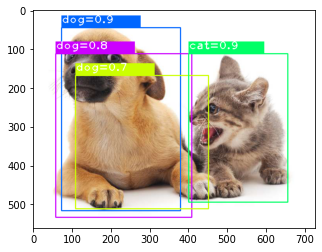

In [ ]:
img = io.imread('http://vicky.kalogeiton.info/assets/catdog.jpeg')
colors = random_colors(boxes_to_print.shape[0])
class_names = ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9']

img1 = print_boxes(img, anchors, bbox_scale, class_names, linewidth=2, colors=colors)
fig = plt.imshow(img1)

We use the `multibox_detection` to detect multiple boxes in the image. 


In [ ]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0), nms_threshold=0.5)
print(output)

tensor([[[ 0.0000,  0.9000,  0.1000,  0.0800,  0.5200,  0.9200],
         [ 1.0000,  0.9000,  0.5500,  0.2000,  0.9000,  0.8800],
         [-1.0000,  0.8000,  0.0800,  0.2000,  0.5600,  0.9500],
         [-1.0000,  0.7000,  0.1500,  0.3000,  0.6200,  0.9100]]])


We remove the prediction bounding boxes of category -1 and visualize the results retained by NMS.


In [ ]:
from copy import deepcopy
img = io.imread('http://vicky.kalogeiton.info/assets/catdog.jpeg')
output2 = deepcopy(output.detach().numpy())
all_classes = ['dog','cat']
output2 = output2[0,np.where(output2[0,:,0] != -1)[0],:]
labels = output2[:,0].astype(int)
classes = []
for idx in labels:
  classes.append(all_classes[idx])

output2 = output2[:,2:]

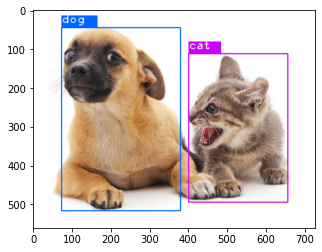

In [ ]:
img = io.imread('http://vicky.kalogeiton.info/assets/catdog.jpeg')
img1 = print_boxes(img, torch.tensor(output2), bbox_scale, classes, linewidth=2, colors=colors)
plt.imshow(img1)